In [1]:
!git clone https://github.com/rtqichen/torchdiffeq.git

Cloning into 'torchdiffeq'...
remote: Enumerating objects: 1121, done.
remote: Counting objects: 100% (417/417), done.
remote: Compressing objects: 100% (179/179), done.
remote: Total 1121 (delta 247), reused 398 (delta 238), pack-reused 704
Receiving objects: 100% (1121/1121), 8.29 MiB | 0 bytes/s, done.
Resolving deltas: 100% (673/673), done.
Checking connectivity... done.


In [2]:
!cd torchdiffeq && pip install -e .

Defaulting to user installation because normal site-packages is not writeable
Obtaining file:///home/mehta.omkar/SSFwithNODE/simple-data-generator/torchdiffeq
  Attempting uninstall: torchdiffeq
    Found existing installation: torchdiffeq 0.2.2
    Uninstalling torchdiffeq-0.2.2:
      Successfully uninstalled torchdiffeq-0.2.2
  Running setup.py develop for torchdiffeq


In [3]:
!ls torchdiffeq/torchdiffeq

_impl  __init__.py


In [217]:
# importing libraries
import os
import time
import numpy as np
import numpy.random as npr
import matplotlib.pyplot as plt
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

# from torchdiffeq.torchdiffeq import odeint

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

from torchdiffeq import odeint, odeint_adjoint
from stockDataTransformer import stockDataTransformer

In [221]:
# time steps ahead that we need to predict
batch_time = 5
# Initial y
batch_size = 200
# to show visualization
viz = True
# FileName
tickerName = 'Apple'
# Filepath
filepath = f"raw-stock-data/{tickerName}.csv"
# Get the data in the required format
data = stockDataTransformer(filepath)
# Total Data Size
data_size = data.shape[0]

# Get Monday's stock data
data = data[:, 0].reshape(data_size, 1)
# Since we now only have Monday's data
dim = 1

def get_batch(i):
    # Get mini batches
    s = torch.arange(i, batch_size+i)  # https://pytorch.org/docs/stable/generated/torch.arange.html
    # print(s)
    # Get the #s initial values from data 
    batch_y0 = true_y[s]  # (M, D): m = number of examples, D = dimension
    # The time steps ahead
    batch_t = t[:batch_time]  # (T)
    # For each initial value, we will have T values 
    batch_y = torch.stack([true_y[s + i] for i in range(batch_time)], dim=0)  # (T, M, D)
    return batch_y0, batch_t, batch_y

# Convert to tensor
# https://pytorch.org/docs/stable/generated/torch.from_numpy.html
true_y = torch.from_numpy(data)  # https://pytorch.org/docs/stable/generated/torch.from_numpy.html
# true_y.shape
# Reshape it to get in (m, 1, dim)
true_y = torch.reshape(true_y, (data_size, 1, dim))  # https://pytorch.org/docs/stable/generated/torch.reshape.html
true_y.shape

# Initial value
true_y0 = torch.reshape(true_y[0:batch_size], (batch_size, 1, dim))
# true_y0

# Time steps
t = torch.linspace(1., 506., data_size)
# t.shape

batch_y0, batch_t, batch_y = get_batch(0)
print(batch_t.shape)
print(batch_y0.shape)
print(batch_y.shape)

class ODEFunc(nn.Module):

    def __init__(self):
        super(ODEFunc, self).__init__()

        self.net = nn.Sequential(
            nn.Linear(dim, 150),
            nn.Tanh(),
            nn.Linear(150, 50),
            nn.Tanh(),
            nn.Linear(50, 50),
            nn.Tanh(),
            nn.Linear(50, dim),
        )
        self.net = self.net.double()
        for m in self.net.modules():
            if isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, mean=0, std=0.1)
                nn.init.constant_(m.bias, val=0)

    def forward(self, t, y):
        return self.net(y)
# func = ODEFunc()

torch.Size([5])
torch.Size([200, 1, 1])
torch.Size([5, 200, 1, 1])


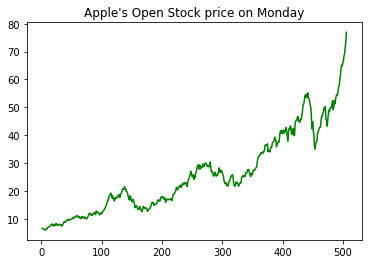

In [214]:
plt.figure()
plt.plot(t.numpy(), true_y.numpy()[:, 0, 0], 'g-')
plt.title(f"Apple's Open Stock price on Monday")
plt.show()

In [215]:
def visualize(t, true_y, pred_y, odefunc, itr):
  
    if viz:
      
        plt.figure()
        plt.plot(t.numpy(), true_y.numpy()[:, 0, 0], 'g-')
        plt.plot(t.numpy(), pred_y.numpy()[:, 0, 0], '--')
        # plt.savefig(DATA_TYPE + '/ts' + str(itr) + '.png')
        plt.show()
        
class RunningAverageMeter(object):
    """Computes and stores the average and current value"""

    def __init__(self, momentum=0.99):
        self.momentum = momentum
        self.reset()

    def reset(self):
        self.val = None
        self.avg = 0

    def update(self, val):
        if self.val is None:
            self.avg = val
        else:
            self.avg = self.avg * self.momentum + val * (1 - self.momentum)
        self.val = val

In [218]:
batch_y0, batch_t, batch_y = get_batch(0)
pred_y = odeint_adjoint(func, batch_y0, batch_t)

In [220]:
pred_y.shape

torch.Size([5, 200, 1, 1])

Iter 0050 | Total Loss 0.501847


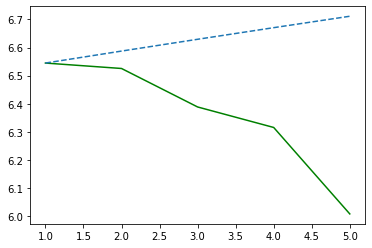

Iter 0100 | Total Loss 0.499785


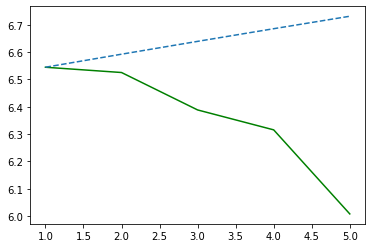

Iter 0150 | Total Loss 0.507753


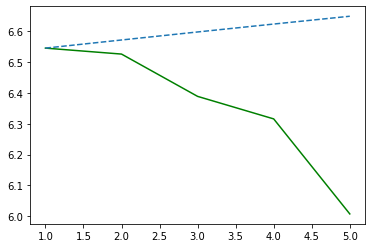

Iter 0200 | Total Loss 0.486259


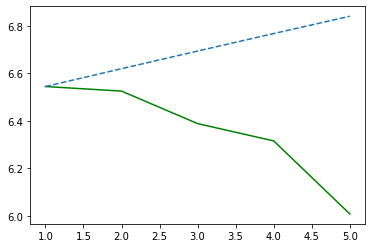

Iter 0250 | Total Loss 0.483842


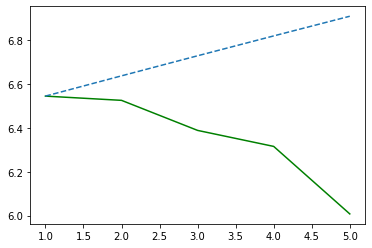

Iter 0300 | Total Loss 0.484126


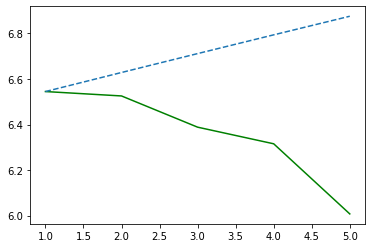

Iter 0350 | Total Loss 0.486525


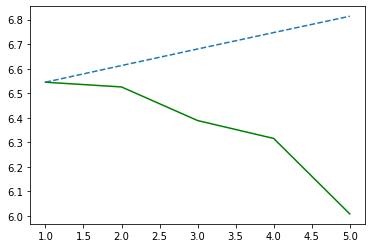

Iter 0400 | Total Loss 0.485774


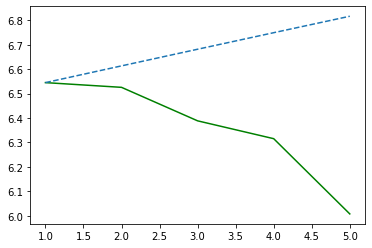

Iter 0450 | Total Loss 0.483828


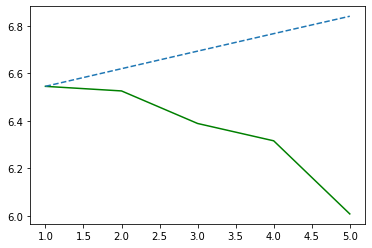

Iter 0500 | Total Loss 0.483389


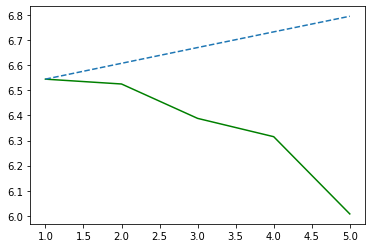

Iter 0550 | Total Loss 0.482563


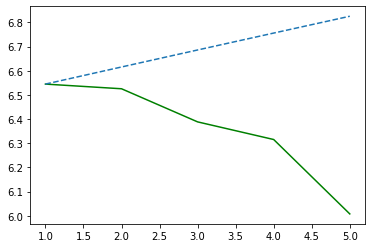

Iter 0600 | Total Loss 0.479469


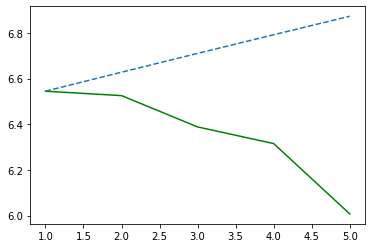

Iter 0650 | Total Loss 0.478458


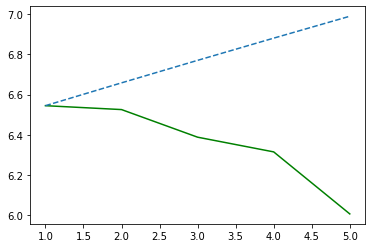

Iter 0700 | Total Loss 0.477078


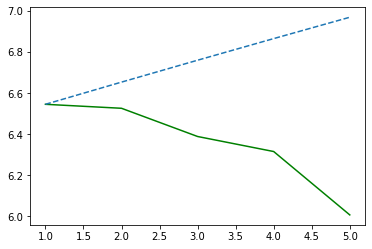

Iter 0750 | Total Loss 0.487090


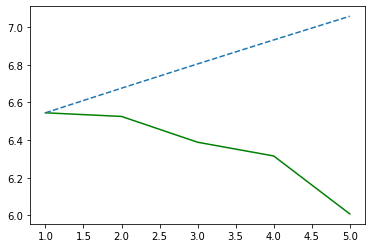

Iter 0800 | Total Loss 0.478426


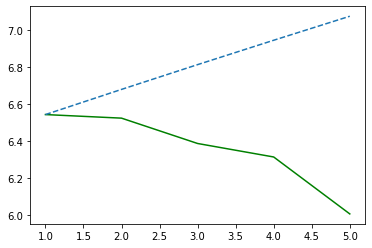

Iter 0850 | Total Loss 0.475935


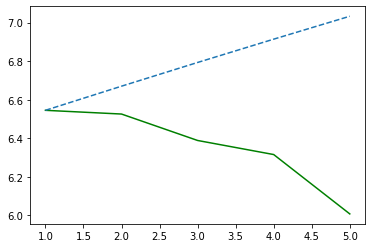

Iter 0900 | Total Loss 0.482425


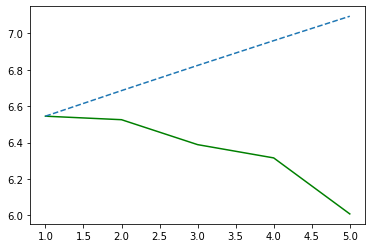

Iter 0950 | Total Loss 0.476402


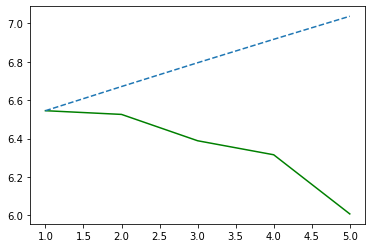

Iter 1000 | Total Loss 0.477311


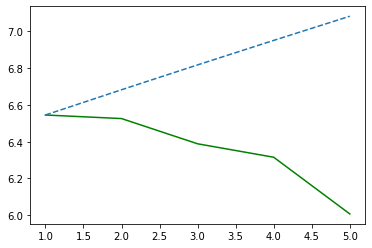

In [216]:
ii = 0
niters = 1000

func = ODEFunc()
optimizer = optim.RMSprop(func.parameters(), lr=1e-3)
end = time.time()

time_meter = RunningAverageMeter(0.97)
loss_meter = RunningAverageMeter(0.97)

for itr in range(1, niters + 1):
    optimizer.zero_grad()
    batch_y0, batch_t, batch_y = get_batch(0)
    pred_y = odeint(func, batch_y0, batch_t)
    # print(pred_y.shape)
    loss = torch.mean(torch.abs(pred_y - batch_y))
    loss.backward()
    optimizer.step()

    time_meter.update(time.time() - end)
    loss_meter.update(loss.item())
    if itr%50==0:
        with torch.no_grad():
            print('Iter {:04d} | Total Loss {:.6f}'.format(itr, loss.item()))
            visualize(batch_t, batch_y, pred_y, func, ii)

#     if itr % 50 == 0:
#         with torch.no_grad():
#             pred_y = odeint(func, true_y0, t)
#             print(pred_y.shape)
#             loss = torch.mean(torch.abs(pred_y - true_y))
#             print('Iter {:04d} | Total Loss {:.6f}'.format(itr, loss.item()))
#             visualize(true_y, pred_y, func, ii)
#             ii += 1

    end = time.time()

In [229]:
# Initial value
true_y0 = torch.reshape(true_y[0:batch_size], (batch_size, 1, dim))
# true_y0

# Time steps
t = torch.linspace(1., 5., 5)
pred_y = odeint(func, true_y0, t)

In [230]:
pred_y.shape

torch.Size([5, 200, 1, 1])

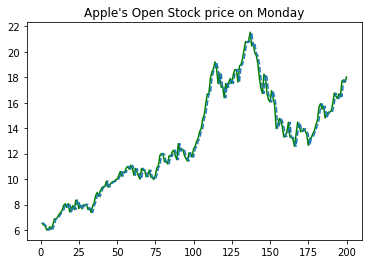

In [241]:
# Time steps
t = torch.linspace(1., batch_size, batch_size)
plt.figure()
plt.plot(t.numpy(), true_y.numpy()[1:201, 0, 0], 'g')
plt.plot(t.numpy(), pred_y.detach().numpy()[0,:, 0, 0], '--')
plt.title(f"Apple's Open Stock price on Monday")
plt.show()